## 频繁项集与关联规则挖掘

## 1.数据导入与查看

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler 
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import Binarizer
from sklearn.feature_selection import VarianceThreshold

In [62]:
#分别导入两个csv并存放到DataFrame df1，df2中
df1 = pd.read_csv(r"C:\Users\Admin\Documents\DataMiningHW2\winemag-data_first150k.csv",index_col=0)
df2 = pd.read_csv(r"C:\Users\Admin\Documents\DataMiningHW2\winemag-data-130k-v2.csv",index_col=0)

In [41]:
print("first150k的shape是%s,130k的shape是%s" %(df1.shape,df2.shape))

first150k的shape是(150930, 10),130k的shape是(129971, 10)


In [16]:
df1.head()

,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez
2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude


In [17]:
df2.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [63]:
#删去df2多出来并且不需要的三个特征"taster_name","taster_twitter_handle","title"
df2.drop(["taster_name","taster_twitter_handle","title"],axis=1,inplace=True)
df2.shape

(129971, 10)

In [64]:
#合并两个DataFrame
df = pd.concat([df1,df2],axis=0)
df.shape

(280901, 10)

In [48]:
#查看数据集的特征的数据类型，为处理缺失值做准备
df.dtypes

country         object
description     object
designation     object
points           int64
price          float64
province        object
region_1        object
region_2        object
variety         object
winery          object
dtype: object

In [46]:
#特征与相应的缺失值个数
[*zip(df.columns,df.dtypes,df.isnull().sum())]
#缺失值少的行直接删去即可，如缺失country,province,variety
#price用mean填充
#designation,region_1,region_2缺失较多，
#如果三者都缺失,用province填充
#如果designation不缺失，填充其余两个
#如果designation缺失，用region1填充其余两个


[('country', dtype('O'), 68),
 ('description', dtype('O'), 0),
 ('designation', dtype('O'), 83200),
 ('points', dtype('int64'), 0),
 ('price', dtype('float64'), 22691),
 ('province', dtype('O'), 68),
 ('region_1', dtype('O'), 46307),
 ('region_2', dtype('O'), 169437),
 ('variety', dtype('O'), 1),
 ('winery', dtype('O'), 0)]

## 2.处理缺失值

In [65]:
#缺失值个数少的特征，直接删去缺失的行
dfc =df.copy()
dfc.dropna(subset=['country','province','variety'],inplace=True)
dfc.isnull().sum()

country             0
description         0
designation     83188
points              0
price           22687
province            0
region_1        46238
region_2       169368
variety             0
winery              0
dtype: int64

In [66]:
#用均值来填充特征price的缺失值
dfc['price'].replace(np.nan,dfc['price'].mean(),inplace=True)
dfc.isnull().sum()


country             0
description         0
designation     83188
points              0
price               0
province            0
region_1        46238
region_2       169368
variety             0
winery              0
dtype: int64

In [ ]:
#如果某一行designation特征缺失，则用此行的province特征来填充
dfc['designation'].replace(np.nan,dfc['province'],inplace=True)


In [86]:
#region_2缺失一半以上，填充已无意义，故删去
dfc.drop(['region_2'],axis=1,inplace=True)
dfc.isnull().sum()


country            0
description        0
designation        0
points             0
price              0
province           0
region_1       46238
variety            0
winery             0
dtype: int64

In [ ]:
#如果某一行region_1特征缺失，则用此行的province特征来填充
dfc['region_1'].replace(np.nan,dfc['province'],inplace=True)

In [ ]:
#将处理好的数据保存
dfc.to_csv(r"C:\Users\Admin\Documents\DataMiningHW2\cleaned_wine.csv")

In [176]:
df3=pd.read_csv(r"C:\Users\Admin\Documents\DataMiningHW2\cleaned_wine.csv",index_col=0)
df3.shape

(280831, 9)

In [177]:
#description 不易挖掘，故删去
df3.drop(['description'],axis=1,inplace=True)

In [173]:
df3

,country,designation,points,price,province,region_1,variety,winery
0,US,Martha's Vineyard,96,235.0,California,Napa Valley,Cabernet Sauvignon,Heitz
1,Spain,Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,Tinta de Toro,Bodega Carmen Rodríguez
2,US,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sauvignon Blanc,Macauley
3,US,Reserve,96,65.0,Oregon,Willamette Valley,Pinot Noir,Ponzi
4,France,La Brûlade,95,66.0,Provence,Bandol,Provence red blend,Domaine de la Bégude
...,...,...,...,...,...,...,...,...
129966,Germany,Brauneberger Juffer-Sonnenuhr Spätlese,90,28.0,Mosel,Burgenland,Riesling,Dr. H. Thanisch (Erben Müller-Burggraef)
129967,US,California,90,75.0,Oregon,Oregon,Pinot Noir,Citation
129968,France,Kritt,90,30.0,Alsace,Alsace,Gewürztraminer,Domaine Gresser
129969,France,Loire Valley,90,32.0,Alsace,Alsace,Pinot Gris,Domaine Marcel Deiss


In [178]:
df3.loc[:,['price']].values.reshape(-1,1)

array([[235.],
       [110.],
       [ 90.],
       ...,
       [ 30.],
       [ 32.],
       [ 21.]])

In [161]:
#将price进行二值化处理，即将price分成两类
#一类是高于price均值两倍的，值为1
#一类是低于price均值两倍的，值为0
price = df3.loc[:,['price']].values.reshape(-1,1)
kbd = Binarizer(threshold=2*np.mean(price))
df3.loc[:,['price']] = kbd.fit_transform(price)
df3

,country,designation,points,price,province,region_1,variety,winery
0,US,Martha's Vineyard,96,1.0,California,Napa Valley,Cabernet Sauvignon,Heitz
1,Spain,Carodorum Selección Especial Reserva,96,1.0,Northern Spain,Toro,Tinta de Toro,Bodega Carmen Rodríguez
2,US,Special Selected Late Harvest,96,1.0,California,Knights Valley,Sauvignon Blanc,Macauley
3,US,Reserve,96,0.0,Oregon,Willamette Valley,Pinot Noir,Ponzi
4,France,La Brûlade,95,0.0,Provence,Bandol,Provence red blend,Domaine de la Bégude
...,...,...,...,...,...,...,...,...
129966,Germany,Brauneberger Juffer-Sonnenuhr Spätlese,90,0.0,Mosel,Burgenland,Riesling,Dr. H. Thanisch (Erben Müller-Burggraef)
129967,US,California,90,1.0,Oregon,Oregon,Pinot Noir,Citation
129968,France,Kritt,90,0.0,Alsace,Alsace,Gewürztraminer,Domaine Gresser
129969,France,Loire Valley,90,0.0,Alsace,Alsace,Pinot Gris,Domaine Marcel Deiss


In [162]:
#一类是高于price中位数的，值为1
#一类是低于price中位数的，值为0
df3['price'].replace(1,'高价',inplace=True)
df3['price'].replace(0,'低价',inplace=True)

In [163]:
from sklearn.preprocessing import KBinsDiscretizer
#将points进行分箱处理，即按照得分高低均匀分成三个箱子
#得分最高的为2
#得分中等的为1
#得分较低的为0
points=df3.loc[:,['points']].values.reshape(-1,1)
est = KBinsDiscretizer(n_bins=3,encode='ordinal',strategy='uniform')
df3.loc[:,['points']] = est.fit_transform(points)
df3

,country,designation,points,price,province,region_1,variety,winery
0,US,Martha's Vineyard,2.0,高价,California,Napa Valley,Cabernet Sauvignon,Heitz
1,Spain,Carodorum Selección Especial Reserva,2.0,高价,Northern Spain,Toro,Tinta de Toro,Bodega Carmen Rodríguez
2,US,Special Selected Late Harvest,2.0,高价,California,Knights Valley,Sauvignon Blanc,Macauley
3,US,Reserve,2.0,低价,Oregon,Willamette Valley,Pinot Noir,Ponzi
4,France,La Brûlade,2.0,低价,Provence,Bandol,Provence red blend,Domaine de la Bégude
...,...,...,...,...,...,...,...,...
129966,Germany,Brauneberger Juffer-Sonnenuhr Spätlese,1.0,低价,Mosel,Burgenland,Riesling,Dr. H. Thanisch (Erben Müller-Burggraef)
129967,US,California,1.0,高价,Oregon,Oregon,Pinot Noir,Citation
129968,France,Kritt,1.0,低价,Alsace,Alsace,Gewürztraminer,Domaine Gresser
129969,France,Loire Valley,1.0,低价,Alsace,Alsace,Pinot Gris,Domaine Marcel Deiss


In [164]:
#得分最高的为2
#得分中等的为1
#得分较低的为0
df3['points'].replace(2,'高分',inplace=True)
df3['points'].replace(1,'中等分',inplace=True)
df3['points'].replace(0,'低分',inplace=True)

In [99]:
#将处理好的数据进行保存
df3.to_csv(r"C:\Users\Admin\Documents\DataMiningHW2\discretized_wine1.csv")

## 3.进行频繁项集与关联规则的挖掘

In [165]:
#由于fpgrowth()只能接受iterable，所以将数据转化成list类型
df3_list=[]
for index in range(df3.shape[0]):
    df3_list.append(df3.iloc[index,:].tolist())
df3_list

[['US',
  "Martha's Vineyard",
  '高分',
  '高价',
  'California',
  'Napa Valley',
  'Cabernet Sauvignon',
  'Heitz'],
 ['Spain',
  'Carodorum Selección Especial Reserva',
  '高分',
  '高价',
  'Northern Spain',
  'Toro',
  'Tinta de Toro',
  'Bodega Carmen Rodríguez'],
 ['US',
  'Special Selected Late Harvest',
  '高分',
  '高价',
  'California',
  'Knights Valley',
  'Sauvignon Blanc',
  'Macauley'],
 ['US',
  'Reserve',
  '高分',
  '低价',
  'Oregon',
  'Willamette Valley',
  'Pinot Noir',
  'Ponzi'],
 ['France',
  'La Brûlade',
  '高分',
  '低价',
  'Provence',
  'Bandol',
  'Provence red blend',
  'Domaine de la Bégude'],
 ['Spain',
  'Numanthia',
  '高分',
  '高价',
  'Northern Spain',
  'Toro',
  'Tinta de Toro',
  'Numanthia'],
 ['Spain',
  'San Román',
  '高分',
  '低价',
  'Northern Spain',
  'Toro',
  'Tinta de Toro',
  'Maurodos'],
 ['Spain',
  'Carodorum Único Crianza',
  '高分',
  '高价',
  'Northern Spain',
  'Toro',
  'Tinta de Toro',
  'Bodega Carmen Rodríguez'],
 ['US',
  'Silice',
  '高分',
  '低价',


## 3.1使用FP-GROWTH

由于FP-Growh运行较快，而我们的数据集较大，且非数值型数据较多，所以先使用FP-Growth进行挖掘来探索比较合适的支持度(Support)和可信度(Confidence)阈值(Threshold)

由于我们的数据集包含很多红酒的产地等信息，所以我们可以接受较低的support，来挖掘出更多的关联规则，但是置信度阈值的选取却并无标准，我们探索让我们来置信度阈值的取值

In [166]:
import matplotlib.pyplot as plt
rules_conf=[]
rules_len=[]
for confidence in np.arange(0.5,0.7,0.03):#置信度在0.5到0.7间探索
    freqItemSet, rules = fpgrowth(df3_list,minSupRatio=0.05,minConf=confidence)
    if len(rules)>30 and len(rules)<100:#如果关联规则的个数在30到100之间
        rules_len.append(len(rules))
        rules_conf.append(confidence)

In [167]:
[*zip(rules_conf,rules_len)]

[]

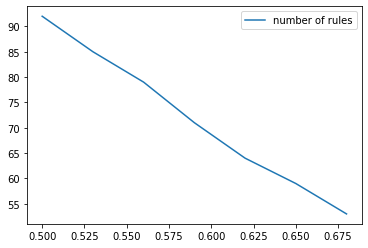

In [140]:
plt.plot(rules_conf,rules_len,label="number of rules")
plt.legend()
plt.show()

可以看到可信度confidence和关联规则的个数几乎是线性负相关的
所以只要我们知道需要选取的关联规则的个数，就可以选取相应的confidence阈值

In [169]:
len(rules)

129

In [168]:
#使用fpgrowth进行频繁项集和关联规则挖掘
from fpgrowth_py import fpgrowth
itemSet = df3_list
freqItemSet, rules = fpgrowth(itemSet,minSupRatio=0.05,minConf=0.6)
#打印挖掘到的关联规则,第三个分数为可信度
print(rules)

[[{'Bordeaux'}, {'France'}, 0.8687357630979499], [{'Bordeaux'}, {'France', '低价'}, 0.8248861047835991], [{'Bordeaux', 'France'}, {'低价'}, 0.949524745984923], [{'Bordeaux', '低价'}, {'France'}, 0.867754979781339], [{'Bordeaux'}, {'低价'}, 0.9505979498861048], [{'Tuscany'}, {'中等分'}, 0.7631830036257236], [{'Tuscany'}, {'Italy'}, 0.8492462311557789], [{'Tuscany'}, {'低价'}, 0.8584059538197316], [{'Red Blend'}, {'低价'}, 0.9135445169438013], [{'高价'}, {'中等分'}, 0.6749507643252368], [{'Cabernet Sauvignon'}, {'US'}, 0.7402539141357498], [{'Cabernet Sauvignon', 'California'}, {'US'}, 0.9688134609805628], [{'Cabernet Sauvignon', 'US'}, {'California'}, 0.8095266953517969], [{'Cabernet Sauvignon'}, {'低价'}, 0.8080839800816473], [{'Cabernet Sauvignon', 'California'}, {'低价'}, 0.725268349289237], [{'Cabernet Sauvignon'}, {'California'}, 0.6185456013637791], [{'Chardonnay', 'US'}, {'低价'}, 0.9811169144234633], [{'Chardonnay', 'California'}, {'US', '低价'}, 0.9299617102744097], [{'Chardonnay', 'US'}, {'California', '

In [181]:
#打印挖掘到的频繁项集
print(freqItemSet)

[{'Oregon'}, {'Bordeaux-style Red Blend'}, {'Spain'}, {'Bordeaux'}, {'Bordeaux', 'France'}, {'Bordeaux', 'France', '低价'}, {'Bordeaux', '低价'}, {'Tuscany'}, {'Tuscany', '中等分'}, {'Italy', 'Tuscany'}, {'Tuscany', '低价'}, {'Red Blend'}, {'Red Blend', '低价'}, {'高价'}, {'高价', '中等分'}, {'Cabernet Sauvignon'}, {'Cabernet Sauvignon', 'US'}, {'Cabernet Sauvignon', 'California', 'US'}, {'Cabernet Sauvignon', '低价'}, {'Cabernet Sauvignon', 'California', '低价'}, {'Cabernet Sauvignon', 'California'}, {'Chardonnay'}, {'Chardonnay', 'US'}, {'Chardonnay', 'US', '低价'}, {'Chardonnay', 'California', 'US', '低价'}, {'Chardonnay', 'California', 'US'}, {'Chardonnay', '中等分'}, {'低价', 'Chardonnay', '中等分'}, {'Chardonnay', 'California'}, {'Chardonnay', 'California', '低价'}, {'Chardonnay', '低价'}, {'Washington'}, {'Washington', '中等分'}, {'Washington', 'US', '中等分'}, {'Washington', '低价', 'US', '中等分'}, {'Washington', '低价', '中等分'}, {'Washington', 'US'}, {'Washington', 'US', '低价'}, {'Washington', '低价'}, {'Pinot Noir'}, {'Californi

## 用apriori挖掘并评估

In [182]:
from efficient_apriori import apriori
itemsets, rules = apriori(df3_list, min_support=0.05, min_confidence=0.7)
# Print out every rule with 2 items on the left hand side,
# 1 item on the right hand side, sorted by lift
rules_rhs = filter(lambda rule: len(rule.lhs) == 2 and len(rule.rhs) == 1, rules)
for rule in sorted(rules_rhs, key=lambda rule: rule.lift):
  print(rule) 

{Italy, 中等分} -> {低价} (conf: 0.896, supp: 0.101, lift: 0.969, conv: 0.729)
{Pinot Noir, 中等分} -> {低价} (conf: 0.899, supp: 0.061, lift: 0.973, conv: 0.750)
{France, 中等分} -> {低价} (conf: 0.902, supp: 0.095, lift: 0.976, conv: 0.774)
{California, US} -> {低价} (conf: 0.915, supp: 0.269, lift: 0.990, conv: 0.889)
{California, 中等分} -> {低价} (conf: 0.916, supp: 0.187, lift: 0.991, conv: 0.901)
{Pinot Noir, US} -> {低价} (conf: 0.919, supp: 0.066, lift: 0.995, conv: 0.941)
{US, 中等分} -> {低价} (conf: 0.928, supp: 0.246, lift: 1.005, conv: 1.061)
{Chardonnay, 中等分} -> {低价} (conf: 0.935, supp: 0.053, lift: 1.011, conv: 1.162)
{US, Washington} -> {低价} (conf: 0.963, supp: 0.066, lift: 1.043, conv: 2.076)
{Washington, 中等分} -> {低价} (conf: 0.969, supp: 0.057, lift: 1.049, conv: 2.446)
{Chardonnay, US} -> {低价} (conf: 0.981, supp: 0.052, lift: 1.062, conv: 4.022)
{California, 低分} -> {低价} (conf: 0.983, supp: 0.109, lift: 1.064, conv: 4.504)
{US, 低分} -> {低价} (conf: 0.985, supp: 0.129, lift: 1.066, conv: 5.178)
{Pin

## 分析
1.{Italy, 中等分} -> {低价} 意大利中等评分一般是底价酒
2.{France, 中等分} -> {低价} 法国类似
3.{Pinot Noir, US} -> {中等分} Pinot Noir产地一般中等分
4.{California, 中等分} -> {低价} 加州中等分一般是低价酒

In [91]:
column=[]
for col in df3.columns:
    column.append(col!='price')
column

[True, True, False, True, True]

In [92]:
df3.loc[:,column]

,country,points,province,variety
0,US,2.0,California,Cabernet Sauvignon
1,Spain,2.0,Northern Spain,Tinta de Toro
2,US,2.0,California,Sauvignon Blanc
3,US,2.0,Oregon,Pinot Noir
4,France,2.0,Provence,Provence red blend
...,...,...,...,...
129966,Germany,1.0,Mosel,Riesling
129967,US,1.0,Oregon,Pinot Noir
129968,France,1.0,Alsace,Gewürztraminer
129969,France,1.0,Alsace,Pinot Gris
